In [2]:
import pandas as pd 
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Pega o diretório onde o script está sendo executado
diretorio_atual = os.getcwd()
arquivos_json = [f for f in os.listdir(diretorio_atual) if f.endswith('.json')]

dfs = []

for i,arquivo in enumerate(arquivos_json):
    with open(os.path.join(diretorio_atual, arquivo), 'r') as f:
        data = json.load(f)
    
    parametros = {
        'neuronios_camada': data['neuronios_camada'],
        'neuronios_saida': data['neuronios_saida'],
        'epocas': data['epocas'],
        'taxa_aprendizado': data['taxa_aprendizado'],
        'camadas': data['camadas'],
        'bias': data['bias'],
        'tipo': data['tipo'],
        'folds': data['folds'],
        'ativacao': data['ativacao']
    }

    for metrica in data['metricas']:
        df = pd.json_normalize(metrica, 
                               record_path='erro_treinamento', 
                               meta=['fold', 'metrica_previsao'],  
                            #    meta_prefix='metrica_',  
                               errors='ignore')
        
        for param, value in parametros.items():
            df[param] = value
        df['id'] = i
        dfs.append(df)

df_final = pd.concat(dfs, ignore_index=True)   

In [4]:
df_final.head()

,epoca,erros_epoca,fold,metrica_previsao,neuronios_camada,neuronios_saida,epocas,taxa_aprendizado,camadas,bias,tipo,folds,ativacao,id
0,0,0.044786,0,0.003805,3,1,100,0.05,2,0,regressao,5,tanh,0
1,1,0.039456,0,0.003805,3,1,100,0.05,2,0,regressao,5,tanh,0
2,2,0.038472,0,0.003805,3,1,100,0.05,2,0,regressao,5,tanh,0
3,3,0.037922,0,0.003805,3,1,100,0.05,2,0,regressao,5,tanh,0
4,4,0.037432,0,0.003805,3,1,100,0.05,2,0,regressao,5,tanh,0


In [5]:
df_reg = df_final[(df_final['tipo']=='regressao') & (df_final['neuronios_camada'] < 4)]

## Analise por Neuronios de saida

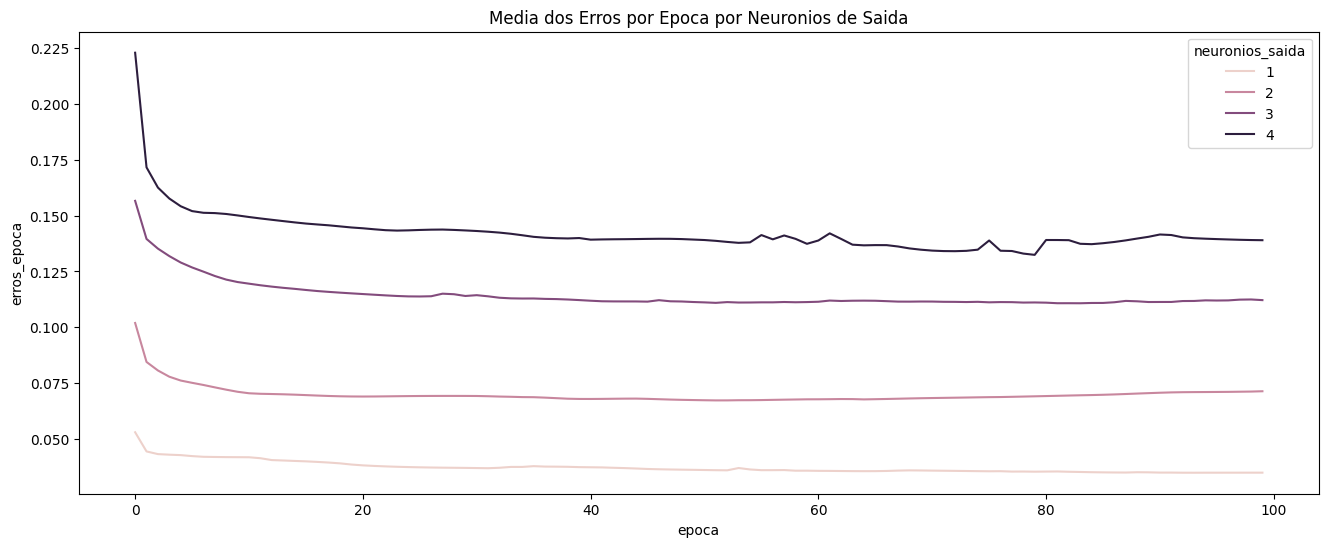

In [57]:
epocas = df_reg.groupby(['epoca','neuronios_saida'])['erros_epoca'].mean().reset_index()
plt.figure(figsize=[16,6])
sns.lineplot(epocas,x='epoca',y='erros_epoca',hue='neuronios_saida')
plt.title('Media dos Erros por Epoca por Neuronios de Saida')
plt.show()

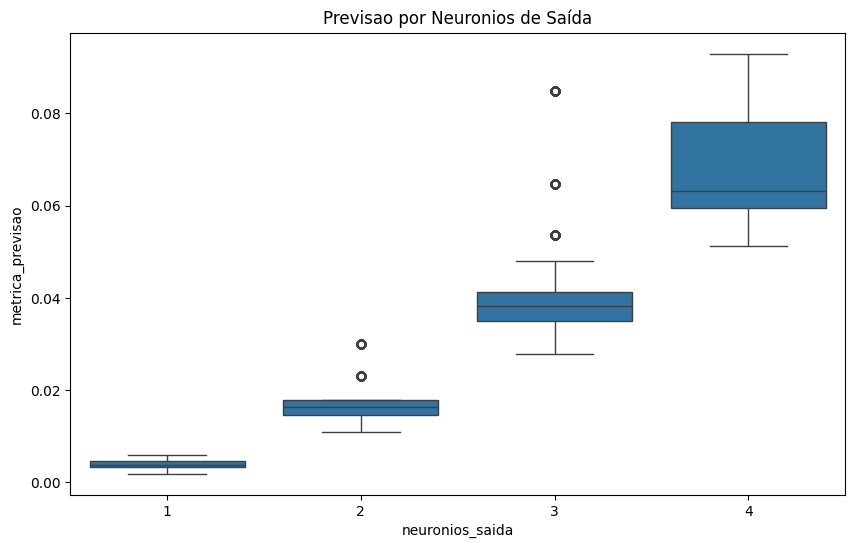

In [7]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_reg, x='neuronios_saida', y='metrica_previsao')
plt.title('Previsao por Neuronios de Saída')
plt.show()

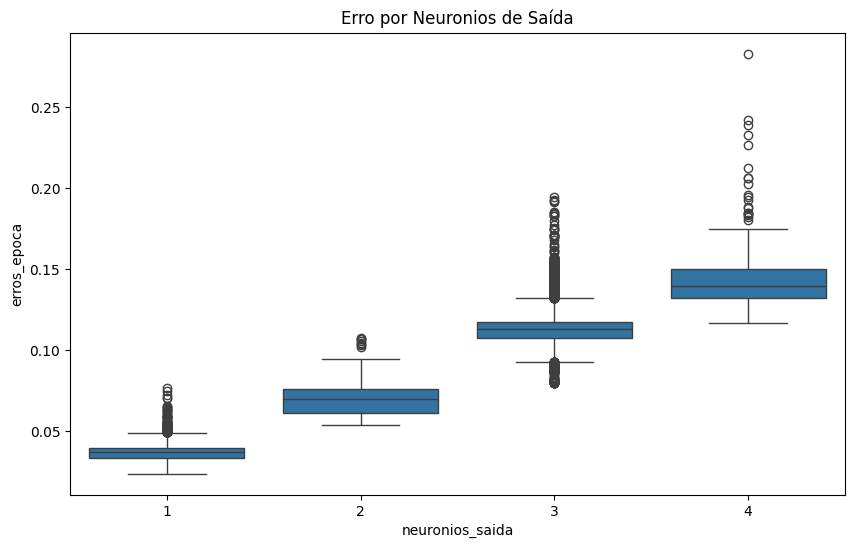

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_reg, x='neuronios_saida', y='erros_epoca')
plt.title('Erro por Neuronios de Saída')
plt.show()

## Analise por numero de camadas

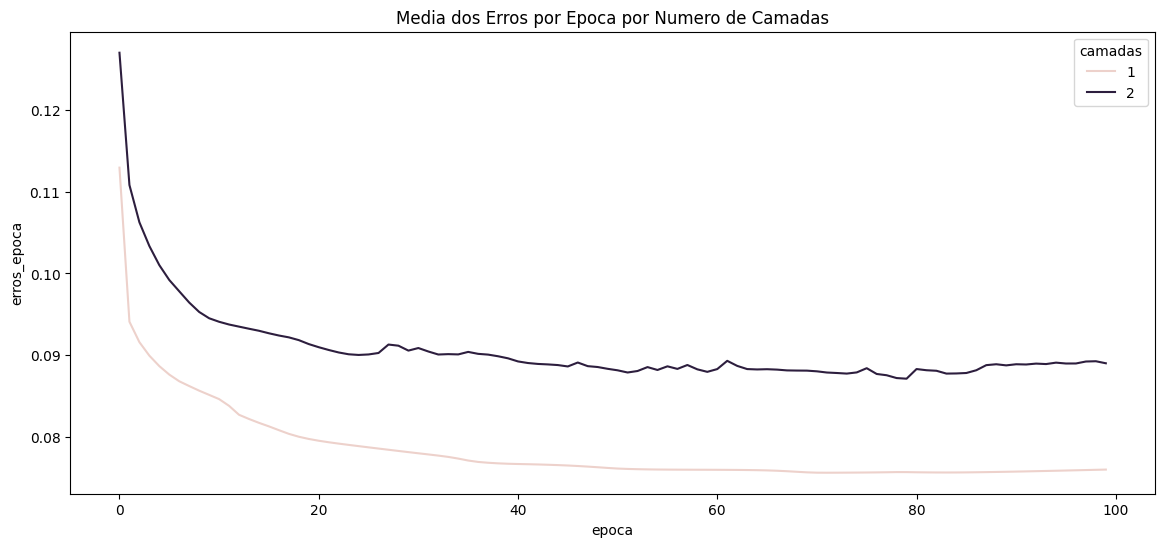

In [55]:
epocas = df_reg.groupby(['epoca','camadas'])['erros_epoca'].mean().reset_index()
plt.figure(figsize=[14,6])
sns.lineplot(epocas,x='epoca',y='erros_epoca',hue='camadas')
plt.title('Media dos Erros por Epoca por Numero de Camadas')
plt.show()

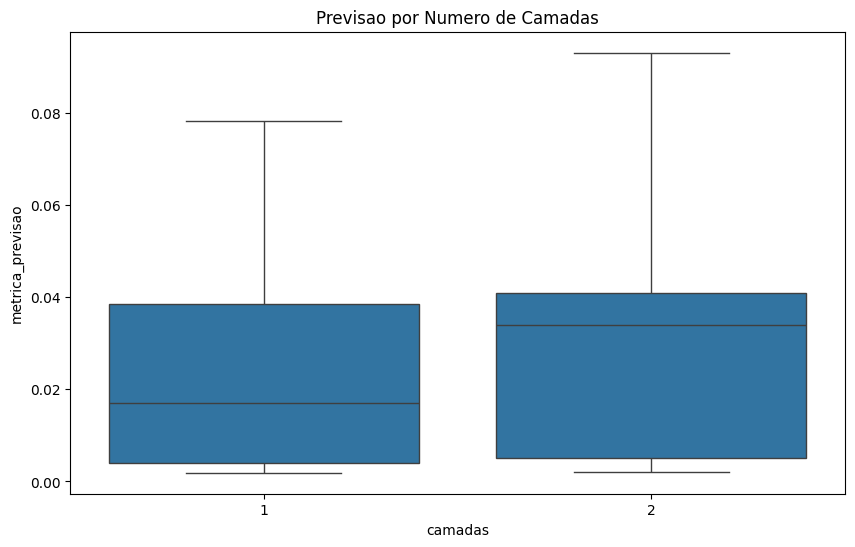

In [54]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_reg, x='camadas', y='metrica_previsao')
plt.title('Previsao por Numero de Camadas')
plt.show()

## Analise por fold

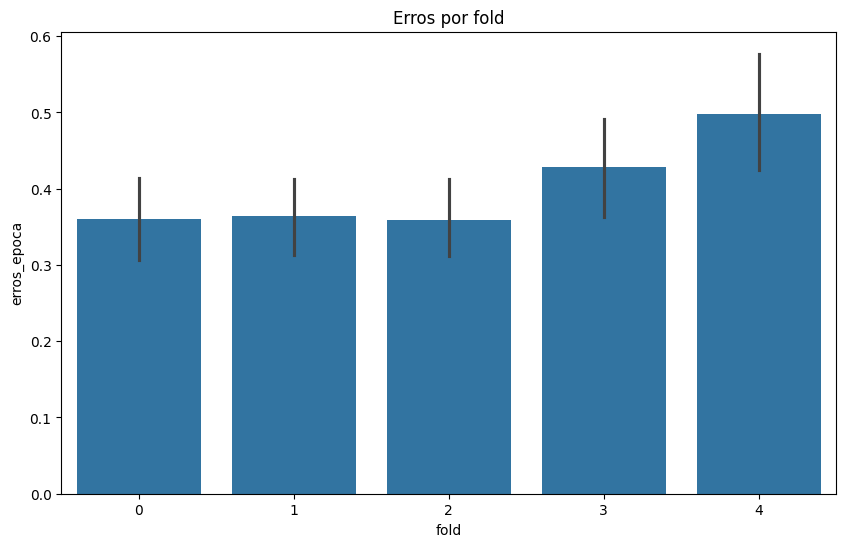

In [12]:
plt.figure(figsize=(10, 6))
sns.barplot(df_final,x='fold',y='erros_epoca')
plt.title('Erros por fold')
plt.show()

In [32]:
df_teste = df_reg.groupby('fold')[['metrica_previsao','erros_epoca']].mean().reset_index()

In [33]:
df_teste = df_teste.melt(var_name='metrica',value_vars=['metrica_previsao','erros_epoca'],id_vars='fold')


Text(0.5, 1.0, 'Comparação entre Métrica Previsão e Erro Época por Fold')

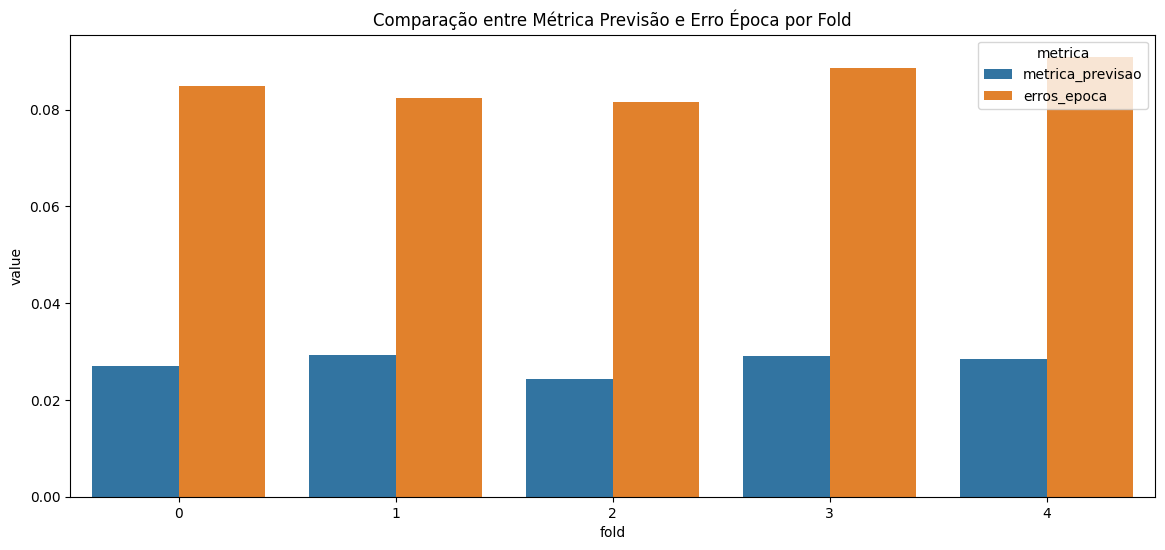

In [52]:
plt.figure(figsize=(14, 6))
sns.barplot(df_teste,x='fold',y='value',hue='metrica')
plt.title("Comparação entre Métrica Previsão e Erro Época por Fold")

<Axes: xlabel='fold', ylabel='erros_epoca'>

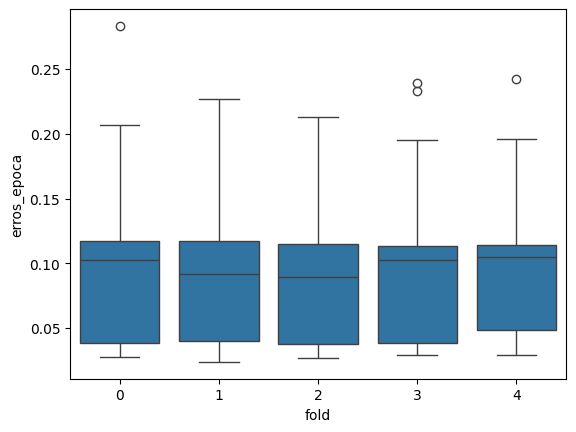

In [34]:
sns.boxplot(df_reg,x='fold',y='erros_epoca')

<Axes: xlabel='fold', ylabel='metrica_previsao'>

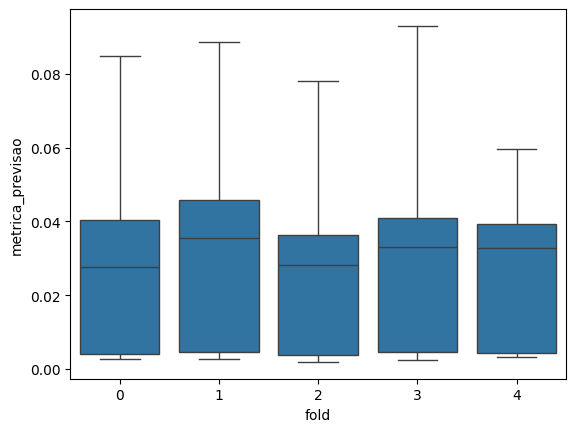

In [35]:
sns.boxplot(df_reg,x='fold',y='metrica_previsao')

## analise epoca

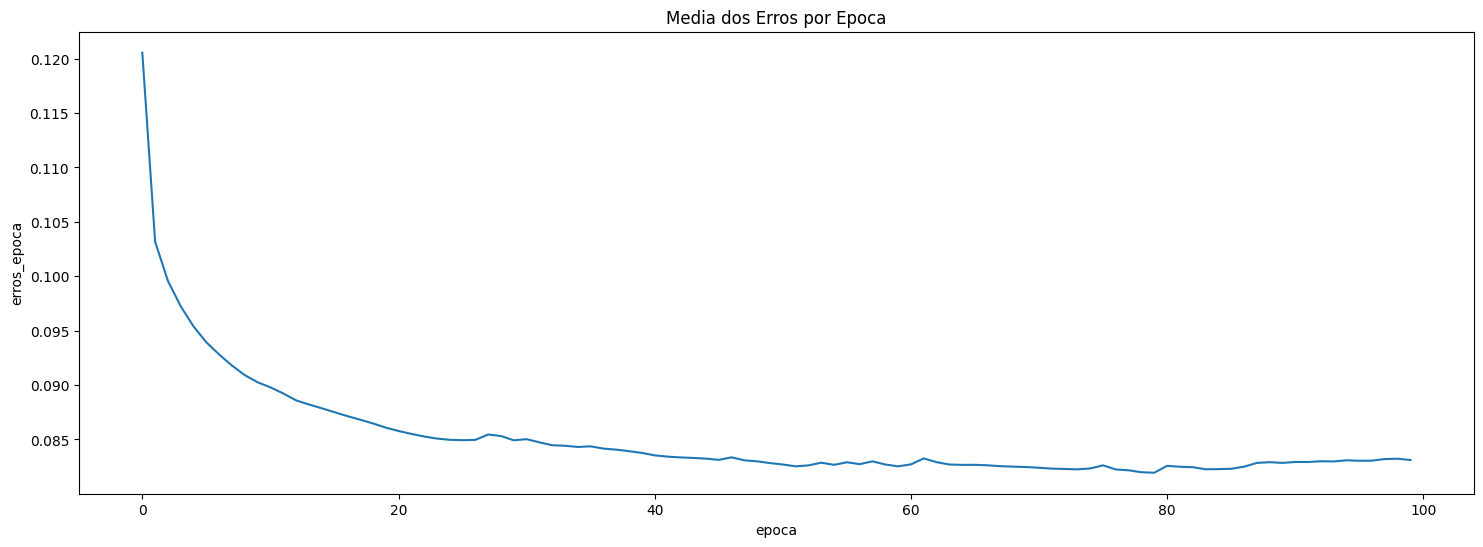

In [51]:
epocas = df_reg.groupby(['epoca'])['erros_epoca'].mean().reset_index()
plt.figure(figsize=[18,6])
sns.lineplot(epocas,x='epoca',y='erros_epoca')
plt.title('Media dos Erros por Epoca')
plt.show()

## Outras analises

In [45]:
tipo = df_reg.groupby(['ativacao'])[['metrica_previsao','erros_epoca']].mean()
tipo

,metrica_previsao,erros_epoca
ativacao,,
sig,0.02995,0.097060
tanh,0.026231,0.079001


In [47]:
# epoca	erros_epoca	fold	metrica_previsao	neuronios_camada	neuronios_saida	epocas	taxa_aprendizado	camadas	bias	tipo	folds	ativacao	id
df_reg.groupby(['camadas','neuronios_saida'])[['metrica_previsao','erros_epoca']].mean()

metrica_previsao  erros_epoca
camadas neuronios_saida                              
1       1                       0.003723     0.036597
        2                       0.015361     0.071603
        3                       0.037379     0.111553
        4                       0.067138     0.140351
2       1                       0.004042     0.038260
        2                       0.019492     0.068293
        3                        0.04089     0.116133
        4                       0.071515     0.144258

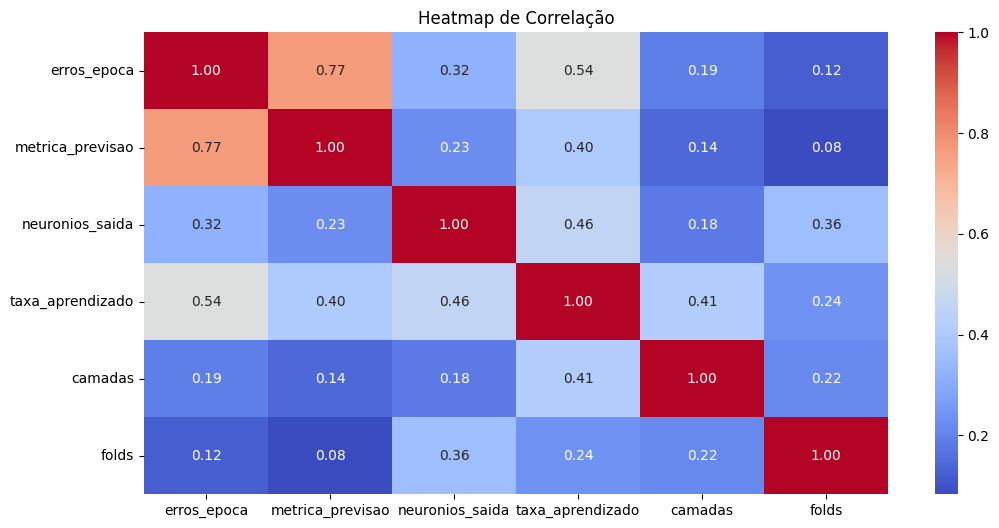

In [14]:
df_corr = df_final[['erros_epoca','metrica_previsao','neuronios_saida','taxa_aprendizado','camadas','folds']]
corr = df_corr.corr()
plt.figure(figsize=(12, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Heatmap de Correlação")
plt.show()